# Machine Learning

In [686]:
%run setup.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [687]:
%store -r hourly hourly_all_stations

In [688]:
hourly_all_stations.head()

,index,interval,cnt_out,ride_duration_out,cnt_in,ride_duration_in,is_holiday,time_since_last_holiday,month,day_of_week,time_of_day,is_weekend,relativehumidity_2m,temperature_2m,wmo_code,windspeed_10m,temperature_apparent
0,1970-01-01,2021-01-01 00:00:00,29,1095.172414,21,774.809524,True,0.0,1,4,0,False,90.0,2.4,1.0,10.2,-6.585167
1,1970-01-01,2021-01-01 01:00:00,33,870.636364,37,776.729730,True,-60.0,1,4,1,False,88.0,1.8,1.0,10.0,-7.181393
2,1970-01-01,2021-01-01 02:00:00,31,660.161290,27,526.000000,True,-120.0,1,4,2,False,87.0,1.1,2.0,10.1,-8.072124
3,1970-01-01,2021-01-01 03:00:00,11,690.000000,17,1511.823529,True,-180.0,1,4,3,False,81.0,1.6,2.0,10.6,-7.988391
4,1970-01-01,2021-01-01 04:00:00,10,1120.900000,10,1081.300000,True,-240.0,1,4,4,False,77.0,1.6,2.0,9.9,-7.588841


In [689]:
hourly.head()

,interval,station_id,cnt_out,ride_duration_out,cnt_in,ride_duration_in,is_holiday,time_since_last_holiday,month,day_of_week,time_of_day,is_weekend,relativehumidity_2m,temperature_2m,wmo_code,windspeed_10m,temperature_apparent
0,2021-01-01,1,1,743.0,0,NaN,True,0.0,1,4,0,False,90.0,2.4,1.0,10.2,-6.585167
1,2021-01-01,4,0,NaN,1,474.0,True,0.0,1,4,0,False,90.0,2.4,1.0,10.2,-6.585167
2,2021-01-01,16,0,NaN,1,585.0,True,0.0,1,4,0,False,90.0,2.4,1.0,10.2,-6.585167
3,2021-01-01,19,1,603.0,1,517.0,True,0.0,1,4,0,False,90.0,2.4,1.0,10.2,-6.585167
4,2021-01-01,21,1,194.0,0,NaN,True,0.0,1,4,0,False,90.0,2.4,1.0,10.2,-6.585167


# Pipeline

In [690]:
# select features for demand prediction per station
features = [
    'temperature_2m', 'relativehumidity_2m', 'windspeed_10m', 'wmo_code', 'temperature_apparent', 
    'is_holiday', 'time_since_last_holiday', 
    'is_weekend',
    'time_of_day', 'day_of_week', 'month',
    'ride_duration_out'
]

features_categorical = [
    'wmo_code',
    'is_holiday', 'is_weekend',
    'time_of_day', 'day_of_week', 'month',
]

features_numerical = [feat for feat in features if feat not in features_categorical]

In [691]:
# pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder, LabelEncoder, 
    MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler,
    FunctionTransformer,
    PolynomialFeatures
    )
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, RidgeCV

In [692]:
from sklearn.model_selection import train_test_split
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.model_selection import TimeSeriesSplit

mask_ml = hourly_all_stations.cnt_out>0

X = hourly_all_stations.loc[mask_ml, features]
y = hourly_all_stations.loc[mask_ml,'cnt_out']
# X = hourly.loc[hourly.cnt_out>0, features]
# y = hourly.loc[hourly.cnt_out>0,'cnt_out']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = temporal_train_test_split(y.astype('int'), X, test_size=0.2)
ts_cv = TimeSeriesSplit(n_splits=5)

# print(f"Training data shape: {X_train.shape}")
# print(f"Test data shape: {X_test.shape}")

In [693]:
# build preprocessor for ML pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown="ignore", sparse_output=False), features_categorical),
        # ('scale', MaxAbsScaler(), features_numerical)
        ('scale', MinMaxScaler(), features_numerical)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [694]:
# linear regression
alphas = np.logspace(-6, 6, 25)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('interactions', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ("ridgecv", RidgeCV(alphas=alphas))
    ])

# pipe.set_output(transform='pandas')
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['wmo_code', 'is_holiday',
                                                   'is_weekend', 'time_of_day',
                                                   'day_of_week', 'month']),
                                                 ('scale', MinMaxScaler(),
                                                  ['temperature_2m',
                                                   'relativehumidity_2m',
                                                   'windspeed_10m',
                                                   'temperature_apparent',
                                                   'time_since_la...
                 RidgeCV(alphas=array([1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06])))])

In [695]:
# gradient boosting
from sklearn.ensemble import HistGradientBoostingRegressor

alphas = np.logspace(-6, 6, 25)
pos_cat_feat = [X.columns.get_loc(feat) for feat in features_categorical] 

pipe_hgbr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('interactions', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ("hgbr", HistGradientBoostingRegressor(categorical_features=pos_cat_feat, random_state=42))
    ])

# pipe.set_output(transform='pandas')
pipe_hgbr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['wmo_code', 'is_holiday',
                                                   'is_weekend', 'time_of_day',
                                                   'day_of_week', 'month']),
                                                 ('scale', MinMaxScaler(),
                                                  ['temperature_2m',
                                                   'relativehumidity_2m',
                                                   'windspeed_10m',
                                                   'temperature_apparent',
                                                   'time_since_last_holiday',
                                                   'ride_duration_out'])],
                                   verbose_feature_names_out=False)),
                ('hgbr',
                 HistGradientBoostingRegressor(categorical_features=[3, 5, 7, 8,
                                                                     9, 10],
                                               random_state=42))])

# Evaluation

In [696]:
from sklearn.model_selection import cross_validate
from collections import defaultdict

def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", 'explained_variance', 'r2'],
        return_estimator=True#model_prop is not None, 
    )
    if model_prop is not None:
        if model_step is not None:
            values = [getattr(m[model_step], model_prop) for m in cv_results["estimator"]]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    
    mae     = -cv_results["test_neg_mean_absolute_error"]
    rmse    = -cv_results["test_neg_root_mean_squared_error"]
    r2      = cv_results["test_r2"]
    evar    = cv_results["test_explained_variance"]
    
    print(f"Mean Absolute Error:\t     {mae.mean():.3f} +/- {mae.std():.3f}")
    print(f"Root Mean Squared Error:\t {rmse.mean():.3f} +/- {rmse.std():.3f}")
    print(f"R2:\t\t\t {r2.mean():.3f} +/- {r2.std():.3f}")
    print(f"Explained Variance:\t  {evar.mean():.3f} +/- {evar.std():.3f}")
    
    coefs = defaultdict(list)
    intercepts = []
    for i, estimator in enumerate(cv_results['estimator']):
        fitted_model = estimator.named_steps[model_step]
        if hasattr(fitted_model, 'coef_'):
            for feature, coef in zip(X.columns, fitted_model.coef_):
                coefs[feature].append(coef)
        if hasattr(fitted_model, 'intercept_'):
            intercepts.append(fitted_model.intercept_)
    print()
    print(coefs)
    print(intercepts)

    return cv_results


In [697]:
# evaluate linear regression
res = evaluate(pipe, X, y, ts_cv, model_prop='alpha_', model_step='ridgecv')
# res

Mean model.alpha_ = 0.008632455532033676
Mean Absolute Error:	     158.814 +/- 39.150
Root Mean Squared Error:	 215.670 +/- 41.363
R2:			 0.556 +/- 0.076
Explained Variance:	  0.628 +/- 0.112

defaultdict(<class 'list'>, {'temperature_2m': [42.687632940127514, 52.379102518665604, 54.37667911860626, 62.799026978667825, 65.83804499544203], 'relativehumidity_2m': [33.939827999216504, 50.57100404247285, 55.96892720148605, 58.16403872636147, 61.29474023729563], 'windspeed_10m': [35.47953384171706, 39.990064374753274, 55.133683120424394, 63.195940189179964, 69.4179645733675], 'wmo_code': [36.52491552667925, 40.72940651277895, 47.48486340872478, 51.5081325006322, 50.437816547753755], 'temperature_apparent': [12.324118615477346, 15.073930987215135, 20.936438456265023, 31.297586908523954, 37.97400953894248], 'is_holiday': [-32.523660925682634, -40.06549492500926, -32.8728304620621, -25.089550271251937, -16.097254319756757], 'time_since_last_holiday': [-27.05802971482626, -44.15188688426133, -36

In [698]:
# evaluate hist gradient boosting regressor
res = evaluate(pipe_hgbr, X, y, ts_cv, model_prop='n_iter_', model_step='hgbr')
# res

Mean model.n_iter_ = 100.0
Mean Absolute Error:	     132.424 +/- 33.308
Root Mean Squared Error:	 183.373 +/- 39.355
R2:			 0.674 +/- 0.084
Explained Variance:	  0.756 +/- 0.101

defaultdict(<class 'list'>, {})
[]


In [699]:
# # Initialize and Train the Model
# pipe.fit(X_train, y_train)

# # Make Predictions
# y_pred = pipe.predict(X_test)

# # Linear regression can predict negative values, which doesn't make sense for ride counts.
# # You might want to clip them at 0 or consider a different model
# y_pred[y_pred < 0] = 0

In [700]:
# from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

# model = pipe.named_steps['ridgecv']

# # Evaluate the Mode
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# explained_var = explained_variance_score(y_test, y_pred)

# print(f"\nModel Intercept: {model.intercept_:.2f}")
# print(f"Model Coefficients:")
# for feature, coef in zip(X.columns, model.coef_):
#     print(f"  {feature}: {coef:.4f}")

# print(f"\nRoot Mean Squared Error (RMSE): {rmse:.2f}")
# print(f"MAE: {mae:.2f}")
# print(f"R-squared: {r2:.4f}")
# print(f"Explained Variance: {explained_var:.4f}")

In [701]:
# Interpretation and Refinement
# Inspect coefficients: Do they make sense? (e.g., negative for wind, positive for temperature up to a point)
# Examine residuals: Plot predicted vs. actual, and residuals vs. predicted to check for patterns.
# Feature importance: Coefficients tell you importance in a linear model.
# Consider more advanced models if linear regression doesn't perform well.

# Prediction

In [702]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[1]

In [703]:
def predict(pipeline, X, y, train_ids, test_ids):
    X_train = X.iloc[train_ids]
    y_train = y.iloc[train_ids]
    pipeline.fit(X_train, y_train)

    X_test = X.iloc[test_ids]
    y_test = y.iloc[test_ids]
    y_pred = pipeline.predict(X_test)
    return y_test, y_pred

y_test, y_pred           = predict(pipe, X, y, train_0, test_0)
y_test_hgbr, y_pred_hgbr = predict(pipe_hgbr, X, y, train_0, test_0)

# X_train = X.iloc[train_0]
# y_train = y.iloc[train_0]
# pipe.fit(X_train, y_train)

# X_test = X.iloc[test_0]
# y_test = y.iloc[test_0]
# y_pred = pipe.predict(X_test)

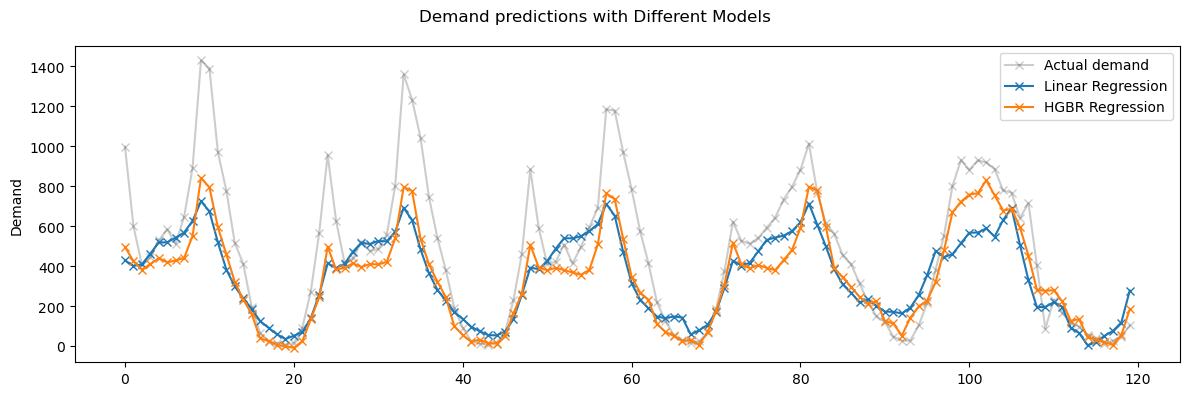

In [704]:
last_hours = slice(-120, None)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Demand predictions with Different Models")
ax.plot(
    y_test[last_hours].values,
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    y_pred[last_hours],
    "x-",
    label="Linear Regression",
)
ax.plot(
    y_pred_hgbr[last_hours],
    "x-",
    label="HGBR Regression",
)
_ = ax.legend()

ax.set_ylabel('Demand')

plt.tight_layout()

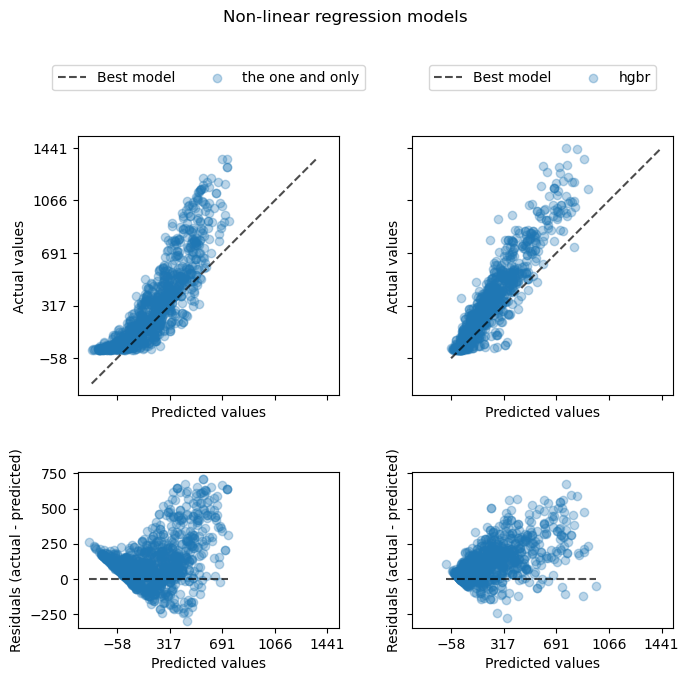

In [705]:
from sklearn.metrics import PredictionErrorDisplay

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 7), sharex=True, sharey="row")
fig.suptitle("Non-linear regression models", y=1.0)

predictions = [
    y_pred,
    y_pred_hgbr
]

labels = [
    'the one and only',
    'hgbr'
]

plot_kinds = ["actual_vs_predicted", "residual_vs_predicted"]
for axis_idx, kind in enumerate(plot_kinds):
    for ax, pred, label in zip(axes[axis_idx], predictions, labels):
        disp = PredictionErrorDisplay.from_predictions(
            y_test,
            pred,
            kind=kind,
            scatter_kwargs={"alpha": 0.3},
            ax=ax,
        )
        # ax.set_xticks(np.linspace(0, 1, num=5))
        if axis_idx == 0:
            # ax.set_yticks(np.linspace(0, 1, num=5))
            ax.legend(
                ["Best model", label],
                loc="upper center",
                bbox_to_anchor=(0.5, 1.3),
                ncol=2,
            )
        ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()